In [1]:
import gc
import random
import re
from collections import Counter, defaultdict

import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm.notebook import tqdm

sns.set()
np.random.seed(7)

layers = keras.layers
models = keras.models

lemmatizer = WordNetLemmatizer()
gc.enable()

Will not use stopwords because, we might need such words as 'we' or 'doesn't for analysis.

In [3]:
import os

In [4]:
# assumed that you have a data if not fetch here :
# https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
os.listdir("aclImdb_v1.tar/aclImdb")

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
path = "aclImdb_v1.tar/aclImdb"
test = path + '/' + "test/"
train = path + '/' + "train/"

In [6]:
os.listdir(test)

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

Let's normalize data anyway :

In [7]:
if not os.path.exists("stem_soup"):
    os.makedirs("stem_soup")

In [8]:
# Read in all files from test and train 50k in total. Remove all symbols except the " ' ", use lemmatization.

sents = ["pos", "neg"]
folders = [train, test]

for folder in folders:
    for sent in sents:
        for file in tqdm(os.listdir(folder + sent)):
            with open(folder + sent + '/' + file, 'r', encoding="utf-8") as f:
                txt = f.readlines()
                txt = ''.join(txt).lower()
                txt = ' '.join(re.findall("[a-zA-Z\s\']+", txt))
                #txt = ' '.join([ stemmer.stem(w) for w in txt.split() if not w in stopwords])
                txt = ' '.join([
                    lemmatizer.lemmatize(w) for w in txt.split()
                    if not w.strip() in [
                        'br', 's', 'ha', 'wa', 'a', 'that', 'this', 'the', 'an'
                    ]  # need to delete "br" manually
                ])

            with open(
                    "stem_soup\\" +
                    file.replace(".txt", "_" + sent + f'_{len(txt)}.txt'
                                 ),  # need len, because files overlap in names
                    'w',
                    encoding="utf-8") as f:
                f.write(txt)

In [9]:
def get_gram(input_list, n):
    '''
    this function return all ngrams in a given sentence
    '''
    return [''.join(t) for t in zip(*[input_list[i:] for i in range(n)])]

In [10]:
scores, labels, lengths = [], [], []

for name in tqdm(os.listdir("stem_soup\\")):
    scores.append(int(name.split("_")[1]))
    labels.append(name.split("_")[2])
    with open("stem_soup\\" + name, encoding="utf-8") as f:
        txt = f.read()
        lengths.append(len(txt.split(' ')))

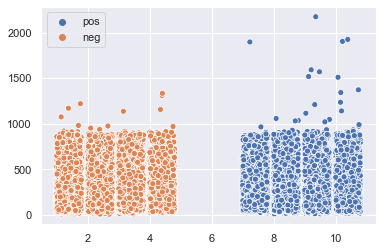

In [11]:
# let's see how classes are distributed

sns.scatterplot(x=scores + np.random.uniform(high=0.8, size=len(scores)),
                y=lengths + np.random.uniform(high=0.8, size=len(scores)),
                hue=labels)

plt.savefig("classes.png", dpi=300)

In [12]:
# Let's predict the sentiment with only 3-grams ?


def default():
    return 1


pos_trigramms = defaultdict(default)
neg_trigramms = defaultdict(default)

for name in tqdm(os.listdir("stem_soup\\")):
    with open("stem_soup\\" + name, encoding="utf-8") as f:
        txt = f.read()
        grams = get_gram(list(txt.replace(" ", '').replace("\n", '')), 3)
        if "pos" in name:
            for g in grams:
                pos_trigramms[g] += 1
        else:
            for g in grams:
                neg_trigramms[g] += 1

pos = sorted(pos_trigramms, key=pos_trigramms.get, reverse=True)[:400]
neg = sorted(neg_trigramms, key=neg_trigramms.get, reverse=True)[:400]

In [13]:
from collections import Counter

pred = []

for name in tqdm(os.listdir("stem_soup\\")[:5000]):
    with open("stem_soup\\" + name, encoding="utf-8") as f:
        txt = f.read()
        grams = get_gram(list(txt.replace(" ", '').replace("\n", '')), 3)
        C = Counter(grams)
        sp = sum([C[p] if p in grams else 0 for k, p in enumerate(pos)])
        sn = sum([C[p] if p in grams else 0 for k, p in enumerate(neg)])

        if sp > sn:
            pred.append("pos")
        else:
            pred.append('neg')

In [14]:
# Baseline on 3-gramms
np.mean(np.array(labels[:5000]) == np.array(pred))

0.6838

#### Conclusions
There is only one task, not two. Since positive comments, are those whose rating is higher than 6*.

It is easy to get an almost random accuracy of 67.

*There are no 5 and 6 rated comments, they are neutral.

*Everything as indicated in the description to the dataset

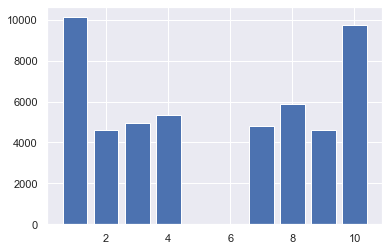

In [15]:
# scores are distributed as following :
sc = Counter(scores)
plt.bar(sc.keys(), sc.values())

In [16]:
trainNames, validNames, trainLabels, _ = train_test_split(os.listdir("stem_soup\\"),
                                                          labels,
                                                          test_size=0.1,
                                                          stratify=labels,
                                                          random_state=7)

trainNames, testNames, trainLabels, _ = train_test_split(trainNames,
                                                         trainLabels,
                                                         test_size=0.1,
                                                         stratify=trainLabels,
                                                         random_state=7)

In [17]:
del lengths, scores

In [18]:
len(trainNames), len(testNames), len(validNames)

(40497, 4500, 5000)

In [19]:
# save test, valid, train names
with open('test.names.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(testNames))

with open('train.names.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(trainNames))

with open('valid.names.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(validNames))

In [20]:
gc.collect()

5367

In [21]:
TEXTS = []
max_words = 40000
for k, file in tqdm(enumerate(trainNames)):
    with open("stem_soup\\" + file, 'r', encoding="utf-8") as f:
        txt = ' '.join(f.readlines())
        TEXTS.append(txt)

In [22]:
# let's mix ngrams on letters with 1-grams on words for very light-weighted model

# 1-grams on words
tokenizer2 = TfidfVectorizer(ngram_range=(1,1),
                             analyzer='word',
                             max_features=max_words,
                             #min_df=0.05,
                             #max_df=1.0,
                             stop_words=None,
                             token_pattern='[a-zA-Z$&+,\':;=?@#|<>.^*()%!-]+') # wont to keep " ' " in "doesn't"

# ngrams on letters
tokenizer1 = TfidfVectorizer(ngram_range=(2, 4),
                             analyzer='char_wb',
                             max_features=max_words,
                             #min_df=0.08,
                             stop_words=None)

tokenizer1 = tokenizer1.fit(TEXTS, np.array(trainLabels) == 'pos')
joblib.dump(tokenizer1, "tokenizer1.vect")
tokenizer2 = tokenizer2.fit(TEXTS, np.array(trainLabels) == 'pos')
joblib.dump(tokenizer2, "tokenizer2.vect")

print(TEXTS[14])

spoiler one of worst film i've seen since last year village insult to anyone of any intelligence at all poorly written and astonishingly contrived nobody especially in los angeles talk way these character do no subtly at all if point of film is to say we all have little bit of bigotry in u he doe horrible job of stating obvious not only wa his point clearly base but every character in film wa amazingly stupid car jacking scene almost made me walk out along with rescue and oh let not forget white off duty rookie cop picking up hitchhiking black thug and i could go on and on awful just awful


In [23]:
del TEXTS

In [24]:
tokenizer2.get_feature_names()

["'",
 "''",
 "''horror''",
 "''i",
 "''oh",
 "''the",
 "'a",
 "'a'",
 "'acrobatty",
 "'act'",
 "'acting'",
 "'action",
 "'action'",
 "'actor'",
 "'actors'",
 "'adult'",
 "'after",
 "'airplane",
 "'airplane'",
 "'alan",
 "'albert",
 "'alice'",
 "'alien'",
 "'all",
 "'amadeus'",
 "'american",
 "'an",
 "'and",
 "'animatronics'",
 "'anna",
 "'another",
 "'anti",
 "'antz'",
 "'apocalypse",
 "'are",
 "'art",
 "'art'",
 "'arthur'",
 "'artsy'",
 "'as",
 "'at",
 "'attack",
 "'aunt",
 "'ave",
 "'avna'",
 "'awful'",
 "'b'",
 "'babe'",
 "'baby",
 "'baby'",
 "'back",
 "'bad",
 "'bad'",
 "'barfly'",
 "'batman",
 "'batman'",
 "'be",
 "'beauty",
 "'beep",
 "'being",
 "'best",
 "'big",
 "'big'",
 "'black",
 "'blade",
 "'blood",
 "'bloody",
 "'blue",
 "'boogie",
 "'bout",
 "'boy",
 "'but",
 "'camilla'",
 "'can",
 "'captain",
 "'casablanca'",
 "'cause",
 "'changi'",
 "'che",
 "'chick",
 "'christmas",
 "'citizen",
 "'city",
 "'civilisation'",
 "'class",
 "'classic",
 "'classic'",
 "'clean'",
 "'clerks'",

In [25]:
# data generator


def read_in(names, i, batch):
    TEXTS = []
    YS = np.zeros((len(names[i:i + batch]), 10))
    for k, file in enumerate(names[i:i + batch]):
        with open("stem_soup\\" + file, 'r', encoding="utf-8") as f:
            txt = ' '.join(f.readlines()).split()
            TEXTS.append(' '.join(txt))
            YS[k] = [
                0 if i != int(file.split('_')[1]) else 1 for i in range(1, 11)
            ]
    return np.array(TEXTS), YS


def train_test_generator(data,
                         tokenizer1,
                         tokenizer2,
                         batch=256,
                         sampleSize=None):
    n_rows = len(data)

    def init():
        return 0

    i = init()
    while True:

        vals, ys = read_in(data, i, batch)
        # print(vals[0])
        yield np.hstack((tokenizer1.transform(vals).todense(),
                         tokenizer2.transform(vals).todense())), ys
        i += batch
        if i >= n_rows:
            i = init()

In [26]:
# let's see into a batch

trainGen = train_test_generator(trainNames,
                                tokenizer1=tokenizer1,
                                tokenizer2=tokenizer2,
                                batch=200)
for batch in trainGen:
    print(batch)
    break

batch[0].shape, batch[1].shape

(matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.09447448, 0.03824156, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]), array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]]))


((200, 80000), (200, 10))

In [27]:
[np.mean(batch[1][:, i]) for i in range(10)]

[0.185, 0.05, 0.14, 0.12, 0.0, 0.0, 0.085, 0.13, 0.095, 0.195]

In [28]:
P = 124

trainGen = train_test_generator(trainNames,
                                tokenizer1=tokenizer1,
                                tokenizer2=tokenizer2,
                                batch=P)

validGen = train_test_generator(validNames,
                                tokenizer1=tokenizer1,
                                tokenizer2=tokenizer2,
                                batch=P)

In [29]:
METRICS = [keras.metrics.CategoricalAccuracy(name="cat_acc")]

In [30]:
# Let's use a dense layer with dropout for easy deployment on Heroku

n_words = batch[0].shape[1]
n_classes = 10


def define_model(n_words=n_words, n_classes=n_classes):
    model = models.Sequential()

    # grams
    model.add(layers.Dense(256, input_shape=(n_words, )))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(rate=0.4))

    # higer grams interactions
    model.add(layers.Dense(64, input_shape=(n_words, )))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(rate=0.4))

    # output 10
    model.add(layers.Dense(n_classes))
    model.add(layers.Activation('sigmoid'))

    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

In [31]:
gc.collect()


def step_decay(epoch):
    initial_lrate = 0.00012
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * drop**(np.floor((1 + epoch) / epochs_drop))
    print(f"\nalpha now : {lrate}\n")
    return lrate


model = define_model()
history = model.fit(trainGen,
                    epochs=100,
                    steps_per_epoch=len(trainNames) // P,
                    verbose=1,
                    validation_data=validGen,
                    validation_steps=len(validNames) // P,
                    callbacks=[
                        keras.callbacks.LearningRateScheduler(step_decay),
                        keras.callbacks.EarlyStopping(patience=7)
                    ])

model.save("model_grams_level.h5")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 40 steps

alpha now : 0.00012

Epoch 1/100
326/326 [==============================] - 196s 603ms/step - loss: 2.1199 - cat_acc: 0.2246 - val_loss: 2.0026 - val_cat_acc: 0.2736

alpha now : 0.00012

Epoch 2/100
326/326 [==============================] - 281s 863ms/step - loss: 1.9065 - cat_acc: 0.3140 - val_loss: 1.6939 - val_cat_acc: 0.3692

alpha now : 0.00012

Epoch 3/100
326/326 [==============================] - 175s 537ms/step - loss: 1.6572 - cat_acc: 0.3745 - val_loss: 1.5577 - val_cat_acc: 0.3991

alpha now : 0.00012

Epoch 4/100
326/326 [==============================] - 174s 533ms/step - loss: 1.5269 - cat_acc: 0.4115 - val_loss: 1.4812 - val_cat_acc: 0.4194

alpha now : 0.00012

Epoch 5/100
326/326 [==============================] - 174s 535ms/step - loss: 1.4342 - cat_acc: 0.4388 - val_loss: 1.4279 - val_cat_acc: 0.4395

alpha now : 0.00012

Epoch 6/100
326/326 [=============================

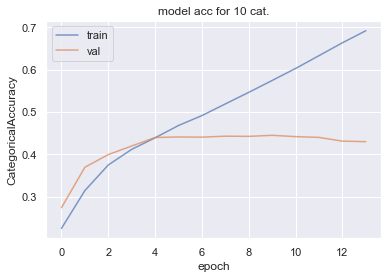

In [32]:
# summarize history for accuracy
plt.plot(history.history['cat_acc'], label='train', alpha=0.7)
plt.plot(history.history['val_cat_acc'], label='val', alpha=0.7)
plt.title(f'model acc for 10 cat.')
plt.ylabel('CategoricalAccuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig("model_cats_acc.png", dpi=300)
plt.show()

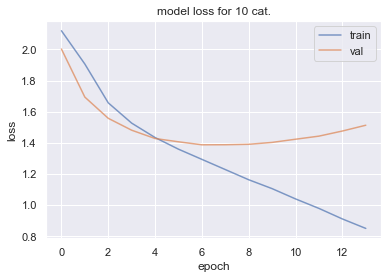

In [33]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='train', alpha=0.7)
plt.plot(history.history['val_loss'], label='val', alpha=0.7)
plt.title(f'model loss for 10 cat.')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig("model_cats_loss.png", dpi=300)
plt.show()

In [34]:
# conducting a Test (unseen data)

testGen = train_test_generator(testNames,
                               tokenizer1=tokenizer1,
                               tokenizer2=tokenizer2,
                               batch=P)

In [35]:
pred = model.predict(testGen, steps=len(testNames) // P, verbose=1)

36/36 [==============================] - 37s 1s/step


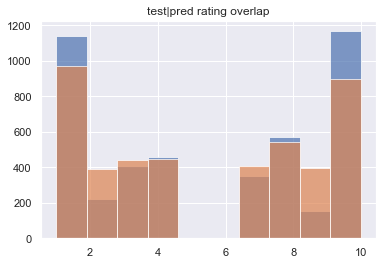

In [50]:
plt.hist(np.argmax(pred, axis=1) + 1, alpha=0.7)
plt.hist([int(n.split('_')[1]) for n in testNames], alpha=0.7)
plt.title("test|pred rating overlap")
plt.savefig("overlap.png", dpi=300)

In [37]:
b = (np.argmax(pred, axis=1) + 1) > 6

In [38]:
a = np.array([int(n.split('_')[1]) for n in testNames]) > 6

In [39]:
# overall binary accuracy score : ~89! (although the data is from 2011, they lend dvds there)
np.mean([aa == bb for aa, bb in zip(a, b)])

0.8980734767025089

In [40]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [41]:
knn = KNeighborsClassifier()
y = np.array([int(n.split('_')[1]) for n in testNames])
S = pred.shape[0]
pred.shape, y.shape

((4464, 10), (4500,))

In [43]:
# can try to use further classification
pred_r = knn.fit(pred, y[:S]).predict(pred)

Text(0.5, 1.0, 'test|pred rating overlap (knn) \n pos/neg acc score 0.8980734767025089')

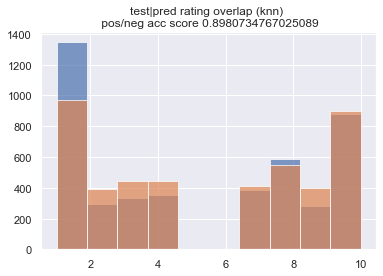

In [44]:
plt.hist(pred_r, alpha=0.7)
plt.hist([int(n.split('_')[1]) for n in testNames], alpha=0.7)
plt.title(f"test|pred rating overlap (knn) \n pos/neg acc score {np.mean([aa == bb for aa, bb in zip(a,b)])}")

In [45]:
l = [int(n.split('_')[1]) for n in testNames]

In [46]:
np.mean([(aa == bb) or (aa == bb - 1) or (aa == bb + 1)
         for aa, bb in zip(l, pred_r)])

0.7540322580645161

In [47]:
vals = ['loved the movie']
vals = np.hstack((tokenizer1.transform(vals).todense(),
                  tokenizer2.transform(vals).todense()))

In [48]:
knn.fit(pred, y[:S])
knn.predict(model.predict(vals).tolist())

array([10])

In [49]:
# save knn
joblib.dump(knn, 'knn.sk')

['knn.sk']

In [51]:
# Dense 1
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases = model.layers[0].get_weights()[1]

# Dense 2
second_layer_weights = model.layers[3].get_weights()[0]
second_layer_biases = model.layers[3].get_weights()[1]

# Dense 2
third_layer_weights = model.layers[6].get_weights()[0]
third_layer_biases = model.layers[6].get_weights()[1]

In [52]:
# save weights for further usage
joblib.dump(first_layer_weights, 'MODEL\\first_layer_weights')
joblib.dump(first_layer_biases, 'MODEL\\first_layer_biases')

joblib.dump(second_layer_weights, 'MODEL\\second_layer_weights')
joblib.dump(second_layer_biases, 'MODEL\\second_layer_biases')

joblib.dump(third_layer_weights, 'MODEL\\third_layer_weights')
joblib.dump(third_layer_biases, 'MODEL\\third_layer_biases')

['MODEL\\third_layer_biases']